# Policy Iteration

Stachurski (2008) Chapter 10

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

## ラムゼーモデル

再掲

In [3]:
class Ramsey:
    """One-sector Ramsey model"""

    def __init__(self, A, α, ρ):
        self.A, self.α, self.ρ = A, α, ρ

    def f(self, x):
        """Production function"""
        return self.A * x ** self.α

    def U(self, x):
        """Utility from consumption"""
        return np.log(x)
    
    def u(self, x, y):
        """Reduced form utility"""
        return self.U(self.f(x) - y)

    def is_feasible(self, x, y):
        """Checks feasibility"""
        return self.f(x) >= y

## 解析解

再掲

In [4]:
def analytic_solutions(A, α, ρ):
    c0 = (1.0 / (1.0 - α * ρ) / (1.0 - ρ) * np.log(A) +
          α * ρ * np.log(α * ρ) / (1.0 - α * ρ) / (1.0 - ρ) +
          np.log(1.0 - α * ρ) / (1.0 - ρ))
    c1 = α / (1.0 - α * ρ) 
    
    def value_func(x):
        return c0 + c1 * np.log(x)
    
    def policy_func(x):
        return ρ * c1 * A * x**α / (1.0 + ρ * c1)  ## Fixed this line
        
    return value_func, policy_func

## 線形近似

前回より実用的に ... 

In [5]:
class PLApprox:  # Refactored this class
    def __init__(self, a, b, N, upsample=10):
        self.a, self.b, self.N = a, b, N
        self.grids = np.linspace(a, b, upsample*N)
        self.centers = np.linspace(a, b, N)
    
    def proj(self, f):
        return np.array([f(c) for c in self.centers])
    
    def inj(self, a):
        return interp1d(self.centers, a)

# Policy Iteration

任意の $x \in X$, に対して $(x, f(x)) \in \mathbb{D}$ を満たす関数 $f$ を policy function という. 

Policy function $f$ と十分大きな $T$ について, その policy function の value

$$
    v_f(x) = \sum_{t=0}^\infty \rho^t u(f^t(x), f^{t+1}(x)) 
    \approx \sum_{t=0}^T \rho^t u(f^t(x), f^{t+1}(x))
$$

In [6]:
def value_of_policy(f, model, apx, T):
    fc = apx.inj(f)
    X = apx.centers
    Y = fc(X)
    vf = np.zeros_like(X)
    for i in range(T):
        vf += model.ρ**i * model.u(X, Y)
        X, Y = Y, fc(Y)
    return vf

Policy の更新則: $f\to v_f \to \hat f$ 

$$
  \hat f (x) = \arg\max_y u(x, y) + \rho v_f(y)
$$

In [7]:
def greedy(vf, model, apx):
    vc = apx.inj(vf)
    Y = apx.grids
    fhat = np.empty_like(vf)
    for i, x in enumerate(apx.centers):
        X = np.ones_like(Y) * x
        with np.errstate(invalid='ignore'):
            maximand = np.where(model.is_feasible(X, Y),
                                model.u(X, Y) + model.ρ*vc(Y),
                                -np.inf)
        fhat[i] = Y[np.argmax(maximand)]
    return fhat

### Policy Iteration Algorithm

\begin{align}
\begin{array}{cccccc}
f_0        &          & f_1        &          & f_2        & \cdots & \to & f^* \\
\downarrow & \nearrow & \downarrow & \nearrow & \downarrow &        &     &     \\
v_0        &          & v_1        &          & v_2        & \cdots & \to & v^* \\
\end{array}
\end{align}

いつものモデルで実験

In [8]:
A, α, ρ =1.1, 0.4, 0.9
ramsey = Ramsey(A, α, ρ)
apx = PLApprox(a=1e-3, b=5.0, N=500, upsample=100)

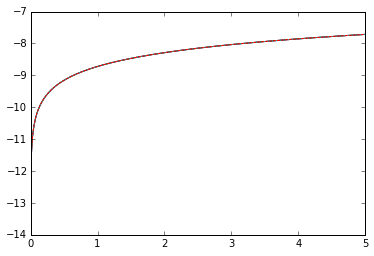

In [9]:
df = apx.proj(lambda x: 0.5 * ramsey.f(x))

fhat = df
for _ in range(10):
    vf = value_of_policy(fhat, ramsey, apx, T=100)
    fhat = greedy(vf, ramsey, apx)

for _ in range(3):
    plt.plot(apx.centers, vf)
    vf = value_of_policy(fhat, ramsey, apx, T=100)
    fhat = greedy(vf, ramsey, apx)
    
v, h = analytic_solutions(A, α, ρ)
plt.plot(apx.grids, v(apx.grids), ':')

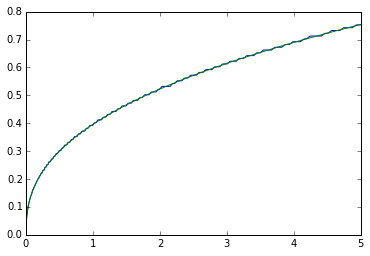

In [10]:
plt.plot(apx.centers, fhat)
plt.plot(apx.centers, h(apx.centers))

## なぜ収束するのか？

$$
f_{n+1}(x) = \arg\max_y u(x, y) + \rho v_n(y)
$$

に対応する作用素

$$
  T_{n+1} w (x) = u(x, f_{n+1}(x)) + \rho w(f_{n+1}(x))
$$

を定義. 

3つの性質に注意:

$$
 T_{n+1} v_{n+1} = v_{n+1}
$$

$$
 T_{n+1} v_n = Tv_n
$$

$$
  v \le w \Longrightarrow T_{n+1}v \le T_{n+1}w
$$

### 価値の単調性

\begin{align}
v_n(x) &= u(x, f_n(x)) + \rho v_n(f_n(x)) \\
       &\le u(x, f_{n+1}(x)) + \rho v_n(f_{n+1}(x)) \\
       &=: T_{n+1} v_n(x) \\
       &\le T_{n+1}^2 v_n(x) \\
       &\le \cdots \\
       &\to v_{n+1}(x)
\end{align}

### Bellman作用素 $T$ との関係

\begin{align}
    T^n v_0 \le v_n \le v^*
\end{align}

#### 証明

$n=0$
のときは自明に成り立つ. 
$n$ まで成り立つとして, 

\begin{align}
    T^{n+1} v_0 = T(T^n v_0) \le Tv_n = T_{n+1} v_n \le T_{n+1} v_{n+1} = v_{n+1}
\end{align}